In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

In [2]:
snap = 51
nbins = 10
bin = 6
r = HBTReader("./data/")

In [3]:
zs = np.genfromtxt('./output/hbtp/redshift_list.txt',\
    dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))

### Load & filter haloes

FoF haloes, filtered such that
- they have more than 2000 particles
- they have at least one subhalo

In [4]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
hs = hs[hs['M200Crit'] >= 20]
hs['M200Crit'] = 1e10*hs['M200Crit']

### Subhalo mass function

In [5]:
ss = r.LoadSubhalos(snap)[['TrackId','HostHaloId','Nbound','Mbound','BoundM200Crit']]
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

In [6]:
counts, bin_edges = np.histogram(np.log10(ss['BoundM200Crit']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])

In [7]:
print counts
print bin_edges
print bins

[  312  2037  3167 10730 18626 27145 27562 21826 13335  6997  3611  1889
   851   374   156    76    33     9     1     1]
[-1.81725681 -1.56450185 -1.3117469  -1.05899194 -0.80623698 -0.55348203
 -0.30072707 -0.04797211  0.20478284  0.4575378   0.71029276  0.96304771
  1.21580267  1.46855763  1.72131258  1.97406754  2.2268225   2.47957745
  2.73233241  2.98508736  3.23784232]
[-1.69087933 -1.43812437 -1.18536942 -0.93261446 -0.6798595  -0.42710455
 -0.17434959  0.07840537  0.33116032  0.58391528  0.83667023  1.08942519
  1.34218015  1.5949351   1.84769006  2.10044502  2.35319997  2.60595493
  2.85870989  3.11146484]


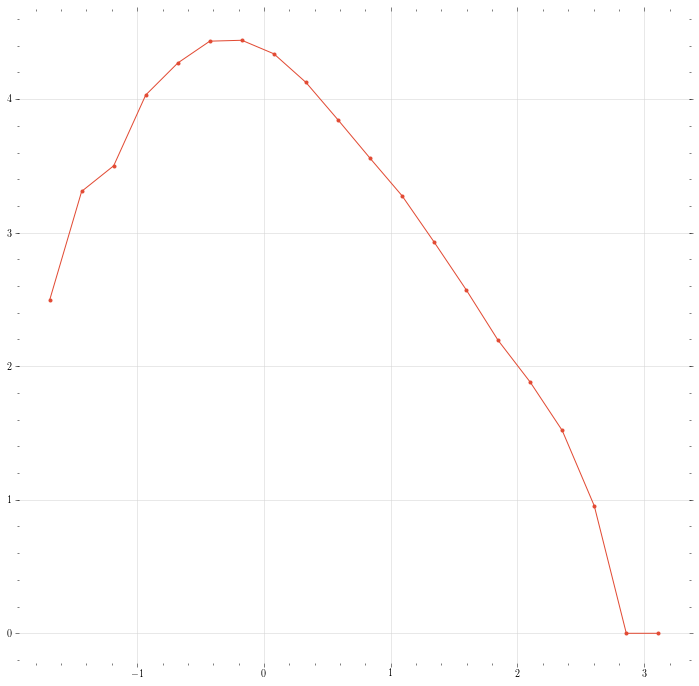

In [8]:
plt.plot(bins, np.log10(counts), marker='.')

In [9]:
print ss[0:10]

[( 1, 137,   8322,   126.75669098,   119.65880585, 16)
 ( 2,  32,   4010,    61.07838821,    38.30726624, 14)
 ( 3,  76,   1892,    28.81803131,    26.44191551, 13)
 ( 4,   7,  32864,   500.56860352,   416.06414795, 18)
 ( 5,  18,  16003,   243.74998474,   205.97581482, 17)
 ( 6, 570,   3278,    49.92891693,    44.12570953, 14)
 ( 7,  24,  19393,   295.38482666,   252.55380249, 17)
 ( 8,  85,  11418,   173.91346741,   144.56233215, 16)
 ( 9,   0, 126743,  1930.48828125,  1729.18859863, 21)
 (10,   6,   1886,    28.72664261,    26.10682106, 13)]


### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [10]:
counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin', np.digitize(np.log10(hs['M200Crit']), bin_edges), usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])

In [11]:
print counts
print bin_edges
print bins

[754 411 193 114  53  33  13   4   1   1]
[ 11.30166912  11.51138258  11.72109604  11.9308095   12.14052296
  12.35023642  12.55994987  12.76966333  12.97937679  13.18909025
  13.39880371]
[ 11.40652585  11.61623931  11.82595277  12.03566623  12.24537969
  12.45509315  12.6648066   12.87452006  13.08423352  13.29394698]


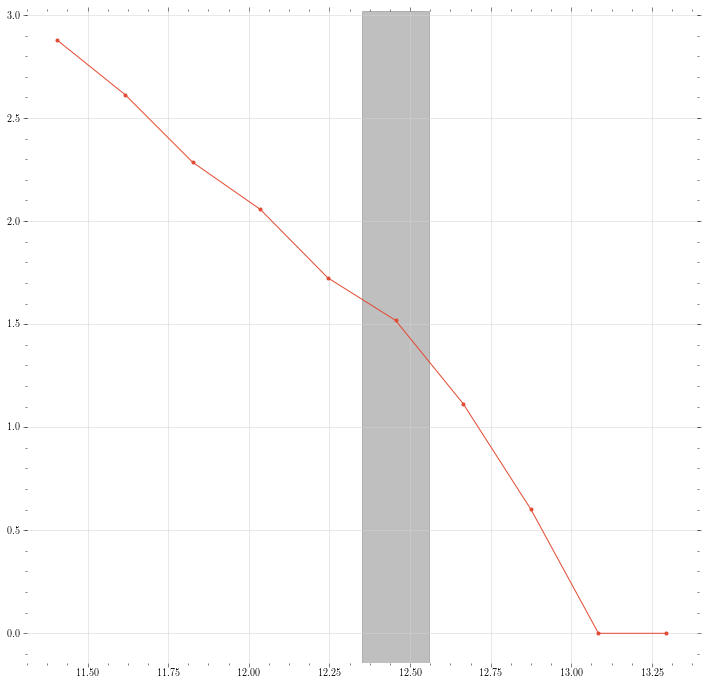

In [12]:
plt.plot(bins, np.log10(counts), marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='grey', alpha=0.5)

### Density profile

In [13]:
prof = np.array(read.prof(snap).loc[hs['bin'] == bin], dtype=np.float)
# prof = np.array([r.GetHostProfile(h, snap, np.logspace(-2.5, 0.0, 33))[0] for h in hs[hs['bin'] == bin]['HaloId']], dtype=np.float)
prof = np.divide(prof.T, np.sum(prof, axis=1)).T
p = np.mean(prof, axis=0)
x = np.linspace(-2.5, 0.0, 32)

In [14]:
c,c_err = nfw.fit(np.power(10.0,x)[:-2], p[:-2])
print c, c_err

3.1395139514 [ 2.01746085  4.71179186]


/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


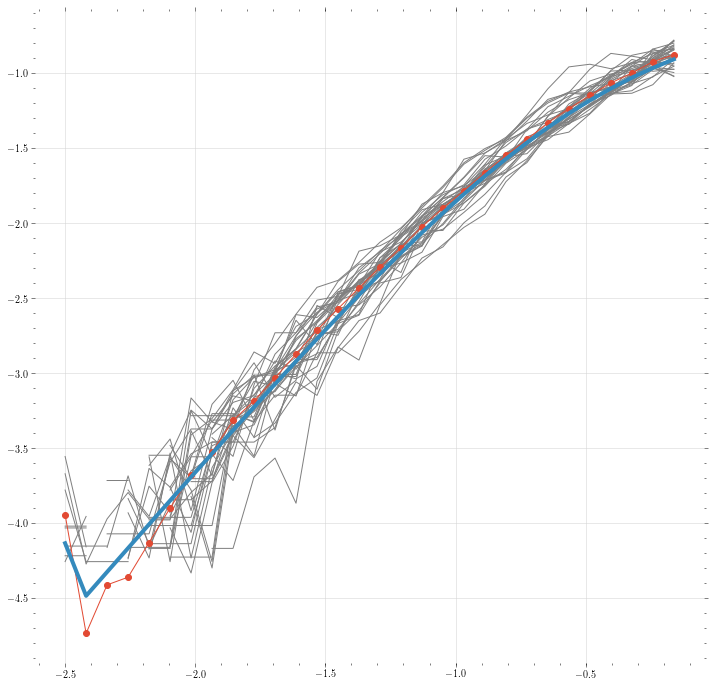

In [15]:
[plt.plot(x[:-2], np.log10(_)[:-2], color='grey') for _ in prof]
plt.plot(x[:-2], np.log10(p[:-2]), marker='o')
plt.plot(x[:-2], np.log10(nfw.m_diff(np.power(10.,x), c)[:-2]), linewidth=4)

### Collapsed Mass History

In [16]:
F = 0.1

In [17]:
f = cmh = np.array(read.cmh(snap).loc[hs['bin'] == bin], dtype=np.float)
cmh = np.divide(cmh.T, cmh[:,-1]).T
m = np.mean(cmh, axis=0)

z = cosmology.rho_c(\
    np.array([zs[zs['snapshot'] == s]['redshift'][0]\
    for s in np.arange(1+snap-cmh.shape[1], 1+snap)]))

z_form = z[np.where(m > F*m[-1])][0]

/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


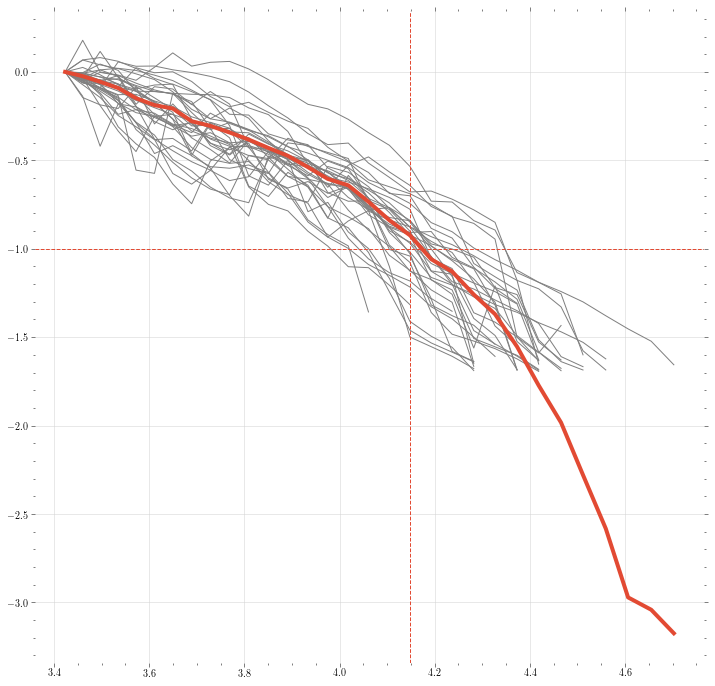

In [18]:
[plt.plot(np.log10(z), np.log10(_), color='grey') for _ in cmh]
plt.plot(np.log10(z), np.log10(np.mean(cmh, axis=0)), linewidth=4)
plt.axhline(np.log10(F*m[-1]), linestyle='--')
plt.axvline(np.log10(z_form), linestyle='--')